<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
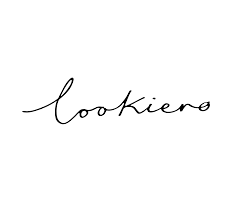
    
---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Procesamiento
En este script se lleva a cabo el procesamiento de los datos. Es decir, se decide qué hacer con los **valores missing**, los **outliers**, **generación de variables...** 

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
from pandas import to_datetime
import numpy as np
import os
import pickle

- **Visualización de datos**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

- **Otros**

In [3]:
import glob
import statistics
import missingno as msno

- **Warnings**

In [4]:
import warnings
warnings.simplefilter(action = 'ignore')
warnings.filterwarnings("ignore")

- **Series temporales**

In [5]:
import datetime
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

- **Finanzas**

In [6]:
import yfinance as yf

* **Prophet**

In [7]:
from prophet import Prophet
from matplotlib import pyplot
from time import sleep

### Funciones básicas
---

In [12]:
dir_in_des, dir_out = "../../datos/datos_desarrollo/", ""
from pickles import abrir_pikle, guardar_pikle

In [13]:
def missing(dff):
    import missingno as msno
    fig1 = plt.figure(figsize = (20, 17))
    for a in range(25):
        ax1 = fig1.add_subplot(5, 5, a + 1)
        msno.matrix(dff[a], fontsize = 12, ax = ax1, sparkline = False);

    fig1.suptitle('Matriz de valores missing por tabla', y = 1.03, size = 20) 
    plt.tight_layout()

### Clases a utilizar
---

Clase para **cargar de datos**
- Se fijan los **directorios** de entrada y salida

In [10]:
dir_in, dir_out = "../../datos/datos_originales/", ""

In [11]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        path = os.getcwd()
        csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []

        for i in csv_files:
            temp_df = pd.read_csv(i)
            dataframes_list.append(temp_df)
        
        return dataframes_list
    
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return pd.read_csv(os.path.join(dir_in, nombre_tabla + ".csv"))

### Carga de datos
---

In [12]:
cd = carga_datos()
dfs = cd.subir_tablas(dir_in)

titulos = [x['symbol'].unique()[0] for x in dfs]
guardar_pikle(titulos, 'titulos')

In [13]:
for df in dfs:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace = True)
    df.reset_index(drop = True, inplace = True)
    df.pop('exchange');

* Se restan **3 horas para tener encuentan las 2:30 como particiapciones del día anterior**

In [14]:
def restar_horas(df):
    df.loc[:,'date'] = df.loc[:,'date'] - timedelta(hours = 3)    
    return df

dfs = list(map(restar_horas, dfs))
for k,v in enumerate(dfs): v['new_date'] = v['date'].dt.strftime('%m/%d/%Y')

In [15]:
def filtrar_ultimos_valores(df):
    for x in df.new_date.unique():
        df_filtrado = df[df['new_date'] == x]
        posicion = df_filtrado.tail(1).index[0]
        if df_filtrado['date'][posicion].hour >= 21: df.drop(posicion, inplace = True)
    return df

In [16]:
dfs_ultimos_valores = list(map(filtrar_ultimos_valores, dfs))
dfs_ultimos_valor = [x.reset_index(drop = True) for x in dfs_ultimos_valores]

### Imputar
---

* #### 1 Imputar la variable ***'open' & 'close'*** 

La variable 'open' no cuenta con valores missing, sin embargo, hay un error que es necesario corregir. Supuestamente el valor de la variable 'open' para un día a de ser constante, pero esto no se ve reflejeda en los dataset. Por otro lado, 'close' sí que cuenta con NAs y cuenta con un error muy similar al ocurrido con la vairable 'open'.

*Este proceso se explica con más detalle en el informe*

In [17]:
def imputar_open_close(df):
    
    df_na = df[df['volume'].isna()]
    
    for k, v in enumerate(df_na['new_date'].unique()):
        posiciones_imputar = df_na[df_na['new_date'] == v].index
        
        if len(df[df['new_date'] == v]) == len(df_na[df_na['new_date'] == v]):
            imputar_open, imputar_close = df[df['new_date'] == v]['open'].head(1).values[0], df[df['new_date'] == v]['close'].tail(1).values[0]
            df.loc[posiciones_imputar, 'open'], df.loc[posiciones_imputar, 'close'] = imputar_open, imputar_close
            
        else:
            valor_imputar_open = float(df[(df['new_date'] == v) & (df['open'].notna())]['open'].head(1))
            valor_imputar_close = float(df[(df['new_date'] == v) & (df['close'].notna())]['close'].tail(1))
            df.loc[posiciones_imputar, 'open'], df.loc[posiciones_imputar, 'close'] = valor_imputar_open, valor_imputar_close
            
    return df

In [18]:
dfs_imputados = list(map(imputar_open_close, dfs_ultimos_valor))

### Cargamos los datos
---

In [20]:
dfs = abrir_pikle('dataframe_limpio_withna')

* Número de **semanas** y **nombre del primer día**

In [21]:
dias = [x['date'].max() - x['date'].min() for x in dfs]
fechas_min, fechas_max = min([x['date'].min() for x in dfs]), max([x['date'].max() for x in dfs])

semanas = (max(dias)/7).days
print('Number of weeks:', semanas)
print('El primer día es:',fechas_min.strftime('%A'))

Number of weeks: 160
El primer día es: Wednesday


### Agrupamos por día
---

* 'last','volume', 'close' 'open' --> **media**
* 'high' --> **max**
* 'low' --> **min**

In [22]:
dfs_agrupados_medias = [(x[['date','open','close','last','volume']].resample('1d', on = 'date').mean()).reset_index() for x in dfs]
dfs_agrupados_minimo = [(x[['date','low']].resample('1d', on = 'date').agg({'low': 'min'})).reset_index() for x in dfs]
dfs_agrupados_maximo = [(x[['date','high']].resample('1d', on = 'date').agg({'high': 'max'})).reset_index() for x in dfs]

* Se juntan

In [23]:
dfs_agrupados = [v.merge(dfs_agrupados_minimo[k]) for k, v in enumerate(dfs_agrupados_medias)]
dfs_agrupados = [v.merge(dfs_agrupados_maximo[k]) for k, v in enumerate(dfs_agrupados)]

### Fines de semana
---

In [24]:
sabado, domingo = "2018-06-09", "2018-06-10"
date_s, date_d = datetime.strptime(sabado, "%Y-%m-%d"), datetime.strptime(domingo, "%Y-%m-%d")

sabados, domingos = [str(date_s + timedelta(days=(7)*x)) for x in range(0, semanas+1)], [str(date_d + timedelta(days=(7)*x)) for x in range(0, semanas+1)]
findes = sabados + domingos

* **Todos los sábados tienen NAs**

In [25]:
dfs_sabados = [v[v['date'].isin(sabados)] for k, v in enumerate(dfs_agrupados)]
print('NA sábados/Total sábados \n \n', [str(len(v[v['volume'].isna()])) +'/'+ str(len(v)) for k, v in enumerate(dfs_sabados)])

NA sábados/Total sábados 
 
 ['160/160', '57/57', '57/57', '57/57', '159/159', '57/57', '57/57', '57/57', '57/57', '57/57', '159/159', '57/57', '57/57', '160/160', '57/57', '57/57', '57/57', '57/57', '57/57', '57/57', '57/57', '159/159', '56/56', '56/56', '56/56', '159/159']


* Todos los **domingos tienen NAs**

In [26]:
dfs_domingos = [v[v['date'].isin(domingos)] for k, v in enumerate(dfs_agrupados)]
print('NA domingos/Total domingos \n \n', [str(len(v[v['volume'].isna()])) +'/'+ str(len(v)) for k, v in enumerate(dfs_domingos)])

NA domingos/Total domingos 
 
 ['160/160', '57/57', '57/57', '57/57', '159/159', '57/57', '57/57', '57/57', '57/57', '57/57', '159/159', '57/57', '57/57', '160/160', '57/57', '57/57', '57/57', '57/57', '57/57', '57/57', '57/57', '159/159', '56/56', '56/56', '56/56', '159/159']


* **Se <font color='red'> eliminan los findes**

In [27]:
dfs_sin_findes = [v[~v['date'].isin(findes)] for k, v in enumerate(dfs_agrupados)]
print('NAs habiendo eliminado los findes:',[max(x.isna().sum()) for x in dfs_sin_findes])

NAs habiendo eliminado los findes: [534, 17, 17, 17, 531, 20, 20, 20, 20, 20, 534, 20, 20, 536, 20, 20, 20, 20, 21, 21, 21, 534, 20, 20, 20, 536]


* Fechas que coinciden con **NAs en open**

In [28]:
lista = ([x[x.open.isna()]['date'].values for x in dfs_sin_findes])

def intersection(lst1, lst2): 
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return lst3

interseccion = lista[0]
for x in range(len(lista)): interseccion = intersection(interseccion, lista[x])
interseccion

[numpy.datetime64('2020-07-03T00:00:00.000000000'),
 numpy.datetime64('2020-09-07T00:00:00.000000000'),
 numpy.datetime64('2020-11-26T00:00:00.000000000'),
 numpy.datetime64('2020-12-25T00:00:00.000000000'),
 numpy.datetime64('2021-01-01T00:00:00.000000000'),
 numpy.datetime64('2021-01-18T00:00:00.000000000'),
 numpy.datetime64('2021-02-15T00:00:00.000000000'),
 numpy.datetime64('2021-04-02T00:00:00.000000000'),
 numpy.datetime64('2021-05-31T00:00:00.000000000')]

* Se borran las fechas que coincida

In [29]:
borrados = [x[~x['date'].isin(interseccion)] for x in dfs_sin_findes]

* Se detectan los **días festivos** de estos años (que no deberían de estar informados) y se **eliminan**

In [30]:
dias_festivos = ['2020-01-01', '2019-01-01', 
                 '2019-01-21', '2020-01-20', 
                 '2019-02-18', '2020-02-17',
                 '2019-04-19', '2020-04-10',
                 '2019-05-27', '2020-05-25',
                 '2018-07-04', '2019-07-04', 
                 '2018-09-03', '2019-09-02', 
                 '2018-11-22', '2019-11-28', 
                 '2018-12-25', '2019-12-25', 
                 '2020-02-29']

borrados_sin_dias = [x[~x['date'].isin(dias_festivos)] for x in borrados]

In [31]:
print('NAs open:', [len(x[x.open.isna()]) for x in borrados_sin_dias])
print('NAs close:',[len(x[x.close.isna()]) for x in borrados_sin_dias])

NAs open: [1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 4, 4, 1, 2, 2, 2, 2, 5, 5, 5, 0, 2, 4, 4, 1]
NAs close: [5, 6, 6, 6, 5, 6, 6, 6, 6, 10, 4, 8, 8, 5, 6, 6, 6, 6, 9, 9, 9, 4, 6, 8, 8, 5]


* **Se eliminan los días anterioers a 2018-06-12**

In [32]:
lista_largos = [0, 4, 10, 13, 21, 25]

for x in lista_largos:
    indices = borrados_sin_dias[x][borrados_sin_dias[x]['date']<'2018-06-12'].index
    borrados_sin_dias[x].drop(indices, inplace = True)
    borrados_sin_dias[x].reset_index(drop = True, inplace = True)

### Imputar open y close
---

In [33]:
for k, v in enumerate(borrados_sin_dias): v['open'], v['close']= v.open.interpolate(), v.close.interpolate()

print('NAs open:', [len(x[x.open.isna()]) for x in borrados_sin_dias])
print('NAs close:',[len(x[x.close.isna()]) for x in borrados_sin_dias])

NAs open: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
NAs close: [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Correción Apple
---

* Ponemos los índices en orden correcto

In [34]:
borrados_sin_dias = [x.reset_index(drop = True) for x in borrados_sin_dias]

* Escogemos el % de crecimiento y le aplicamos la **inversa para añadirse**

In [35]:
serie = borrados_sin_dias[0].close.pct_change()
indice = serie[(serie < -0.5) | (serie > 0.5)].index[0]
valor = serie[(serie < -0.5) | (serie > 0.5)].values[0]

In [36]:
for x in ['open','last', 'volume','low','high']: borrados_sin_dias[0].iloc[indice-1:][x] = borrados_sin_dias[0].iloc[indice-1:][x] * ((1-abs(valor))**-1)
borrados_sin_dias[0].iloc[indice:]['close'] = borrados_sin_dias[0].iloc[indice-1:]['close'] * ((1-abs(valor))**-1)

### Imputación de días faltantes mediante Prophet
---

Dado que algunos de los datasets cuentan con valores no informeres en las primeras instancias de la serie realizar una interpolación puede ser difícil. Por ende, se decide llevar a acabo úna predicción de la serie dado la vuelta. De esta forma se estarían precidiendo los valores **pasados** como si estos **fueran futuros**. Una vez realizado los predicciones se comprueban si estas son coherentes y se concluye que **si lo son.**
* **Funciones para la imputación**

In [9]:
def transformar(dff, variable ='close', reverse = True):
    df = dff[['date']].copy()
    df = pd.DataFrame()
    if reverse == True: df['date'], df[variable] =  dff[['date']].values, dff[[variable]].iloc[::-1].reset_index(drop = True).values
    else: df['date'], df[variable] =  dff[['date']].values, dff[[variable]].values
    df = df.rename(columns={variable: "y", 'date': 'ds'})
    df = df.sort_values('ds', ascending = True)
    df['ds'] = df['ds'].dt.tz_convert(None)
    
    return df

def prediccion_prophet(dff, periods):
    m = Prophet(changepoint_prior_scale=0.5, yearly_seasonality=True, daily_seasonality=True, interval_width=0.85)
    model = m.fit(dff)

    future = m.make_future_dataframe(periods=periods, freq = "D")
    forecast = m.predict(future)

    nuevos_valores =  forecast.tail(periods)['yhat'].values.tolist()
    return nuevos_valores

* Primeramente se corrigen aquellos a los que les faltan 2 días (no existen). **datasets --> 22, 23, 24**

In [38]:
for x in [22, 23, 24]:
    
    df = transformar(borrados_sin_dias[x])
    nuevos_valores = prediccion_prophet(df, 2)
    
    fechas = [borrados_sin_dias[x]['date'][0] - timedelta(days = 4), borrados_sin_dias[x]['date'][0] - timedelta(days = 1)]
    NAs = [np.nan] * 2
    dataframe = pd.DataFrame({'date': fechas, 'open': NAs, 'close': nuevos_valores, 'last': NAs, 'volume':NAs, 'low':NAs, 'high':NAs })
    
    borrados_sin_dias[x] = pd.concat([dataframe, borrados_sin_dias[x]])
    borrados_sin_dias[x].reset_index(drop = True, inplace = True)

* Se imputan los 4 Nas en close del **dataset 9** (son los 4 primeros valores de la serie)

In [39]:
df = transformar(borrados_sin_dias[9])
nuevos_valores = prediccion_prophet(df, 4)
borrados_sin_dias[9]['close'][:4] = nuevos_valores

### Imputar 2018/2019
---

* Series temporales con datos desde 2018: **[0, 4, 10, 13, 21, 25]**

Se extrae el nombre de las acciones que no están informadas en los años 2018/2019

In [40]:
sin_2018 = list(set(range(26)).difference([0, 4, 10, 13, 21, 25]))

In [41]:
titulos = list(pd.concat(dfs).symbol.unique())
titulos_sin2018 = [titulos[e] for e in sin_2018]
df_sin2018 = [borrados_sin_dias[e] for e in sin_2018]

Se descarga la **información mediante la API de *yfinance*** desde la primera fecha hasta la última, para poder comparar los datos informados y sacar la variabilidad entre ambas fuentes de información.

In [42]:
def extraer_info(dataframe):
    return dataframe.history(start = '2018-06-12', end = '2021-07-01', auto_adjust = False)

df_yf = list(map(yf.Ticker, titulos_sin2018))
df_yfinance = list(map(extraer_info, df_yf))

Se añade el nombre de la acción a cada *dataframe*

In [43]:
for dataframe, symb in zip(df_yfinance, titulos_sin2018): dataframe['symbol'] = symb

Se puede observar cómo los datos descargados de la API *yfinance* **sufren algún tipo de desajuste temporal**, ya que, si a cada instancia de estos se les añade un día (el desajuste temporal observado), se concluye que ambas series temporales son casi identicas

In [44]:
def sumar_dia(dataframe_entrada):
    
    dataframe = dataframe_entrada.copy()
    dataframe = dataframe.reset_index()
    dataframe.Date = dataframe.Date + timedelta(days = 1)
    dataframe.columns = dataframe.columns.str.lower()
    dataframe = dataframe.iloc[:-1]
    
    return dataframe[['date','open', 'close', 'volume', 'high', 'low', 'symbol']]

df_yfinance = list(map(sumar_dia, df_yfinance))

Aun así se opta por **calcular el porcentaje de diferencia entre ambas fuentes para poder aplicarlo a los datos que solo son de una fuente**

In [45]:
def variabilidad_entre_fuentes(reto, finanzas):
    
    columns = ['open', 'close', 'volume', 'high', 'low']
    common_dates = pd.to_datetime(list(set(finanzas.date.astype('str')).intersection(reto.date.dt.strftime('%Y-%m-%d').astype('str'))))

    fin = finanzas.loc[finanzas.date.isin(common_dates), columns].reset_index(drop = True)
    ret = reto.loc[reto.date.isin(common_dates), columns].reset_index(drop = True)

    porcentajes = ((ret - fin) / fin).mean()

    fecha_inicio = pd.to_datetime('2018-06-12')
    fecha_fin = pd.to_datetime('2020-06-02')

    resultado = finanzas.loc[(finanzas.date >= fecha_inicio) & (finanzas.date <= fecha_fin), columns] * (porcentajes + 1)
    resultado['date'] = finanzas.loc[(finanzas.date >= fecha_inicio) & (finanzas.date <= fecha_fin), 'date']

    return resultado

df_2018 = list(map(variabilidad_entre_fuentes, df_sin2018, df_yfinance))

Se **junta** y **se adecuan las fechas**

In [46]:
b = 0
for a in range(26):
    borrados_sin_dias[a].date = pd.to_datetime(borrados_sin_dias[a].date.dt.strftime('%Y-%m-%d'))
    if a in sin_2018:
        borrados_sin_dias[a] = pd.concat([df_2018[b], borrados_sin_dias[a]]).reset_index(drop = True)
        b += 1
        
    borrados_sin_dias[a] = borrados_sin_dias[a][borrados_sin_dias[a].date >= pd.to_datetime('2018-06-12')]

* Observando los datos nos damos cuenta que no existe practciamente **ningún lunes, pero si todos los sábados**. Dicho esto y para asemejar los datos a los ya presentes se decide que estos sábados en verdad son lunes. Esto se debe al desajuste previamnete corregido.

In [47]:
df_imputar = list(set(range(26)).difference([0, 4, 10, 9, 13, 21, 25]))

for x in df_imputar:
    filtrados = borrados_sin_dias[x][borrados_sin_dias[x]['date'].isin(sabados)]
    sabados_corregir, indices = list(filtrados.date.values), list(filtrados.index)
    lunes_filtrados = [str(datetime.strptime(str(x)[:-19], "%Y-%m-%d") + timedelta(days = 2)) for x in sabados_corregir]
    lunes_filtrados = [pd.to_datetime(x) for x in lunes_filtrados]
    borrados_sin_dias[x].date.iloc[indices] = lunes_filtrados
    borrados_sin_dias[x].date = pd.to_datetime(borrados_sin_dias[x].date)

* Una vez relaizado el cambio de fechas se compruebas cuentas fechas coinciden en relación a los *dataframes* que ya contaban con datos hasta 2018

In [48]:
fechas_coincidir = list(borrados_sin_dias[10].date.values)
for x in df_imputar: 
    borrados_sin_dias[x] = (borrados_sin_dias[x].resample('1d', on = 'date').mean()).reset_index()
    borrados_sin_dias[x] = borrados_sin_dias[x][borrados_sin_dias[x]['date'].isin(fechas_coincidir)]

* Los nuevos datos **solo cuentan con 19 NAs**

In [49]:
print([len(x[x['close'].isna()]) for x in borrados_sin_dias])

[0, 19, 19, 19, 0, 19, 19, 19, 19, 0, 0, 19, 19, 0, 19, 19, 19, 19, 19, 19, 19, 0, 19, 19, 19, 0]


* Estos se imputan mediante una **interpolación**

In [50]:
for k, v in enumerate(borrados_sin_dias): v['open'], v['close']= v.open.interpolate(), v.close.interpolate()
borrados_sin_dias = [x.reset_index(drop = True) for x in borrados_sin_dias]

Se guardan los datos

## Pruebas del prophet
---

In [14]:
borrados_sin_dias = abrir_pikle('dataframe_analizar')

In [45]:
df = pd.DataFrame()
df[['date','close']] =  borrados_sin_dias[1][['date','close']]
df = df.rename(columns={'close': "y", 'date': 'ds'})
df = df.sort_values('ds', ascending = True)

In [46]:
m = Prophet(changepoint_prior_scale=0.5, yearly_seasonality=True, daily_seasonality=True, interval_width=0.85)
model = m.fit(df)
future = m.make_future_dataframe(periods=100, freq = "D")

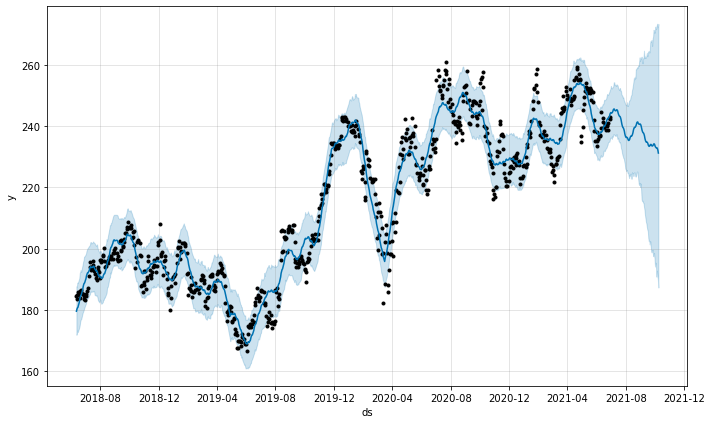

In [47]:
forecast = m.predict(future)
plotl = m.plot(forecast)